In [1]:
# Additional Dependencies
!pip install barbar torchsummary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import copy
import pickle
from barbar import Bar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 0

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [3]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        if self.downsample is not None:
            shortcut = self.downsample(x)

        out += shortcut
        out = self.relu(out)

        return out

In [4]:
class DeconvBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=2, stride=1, upsample=None):
        super(DeconvBottleneck, self).__init__()
        self.expansion = expansion
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if stride == 1:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                                   stride=stride, bias=False, padding=1)
        else:
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels,
                                            kernel_size=3,
                                            stride=stride, bias=False,
                                            padding=1,
                                            output_padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.upsample = upsample

    def forward(self, x):
        shortcut = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)

        if self.upsample is not None:
            shortcut = self.upsample(x)

        out += shortcut
        out = self.relu(out)

        return out

In [5]:
class ResNet_autoencoder(nn.Module):
    def __init__(self, downblock, upblock, num_layers, n_classes=3):
        super(ResNet_autoencoder, self).__init__()

        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_downlayer(downblock, 64, num_layers[0])
        self.layer2 = self._make_downlayer(downblock, 128, num_layers[1],
                                           stride=2)
        self.layer3 = self._make_downlayer(downblock, 256, num_layers[2],
                                           stride=2)
        self.layer4 = self._make_downlayer(downblock, 512, num_layers[3],
                                           stride=2)

        self.uplayer1 = self._make_up_block(
            upblock, 512,  num_layers[3], stride=2)
        self.uplayer2 = self._make_up_block(
            upblock, 256, num_layers[2], stride=2)
        self.uplayer3 = self._make_up_block(
            upblock, 128, num_layers[1], stride=2)
        self.uplayer4 = self._make_up_block(
            upblock, 64,  num_layers[0], stride=2)

        upsample = nn.Sequential(
            nn.ConvTranspose2d(self.in_channels,  # 256
                               64,
                               kernel_size=1, stride=2,
                               bias=False, output_padding=1),
            nn.BatchNorm2d(64),
        )
        self.uplayer_top = DeconvBottleneck(
            self.in_channels, 64, 1, 2, upsample)

        self.conv1_1 = nn.ConvTranspose2d(64, n_classes, kernel_size=1, stride=1,
                                          bias=False)

    def _make_downlayer(self, block, init_channels, num_layer, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != init_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, init_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(init_channels * block.expansion),
            )
        layers = []
        layers.append(
            block(self.in_channels, init_channels, stride, downsample))
        self.in_channels = init_channels * block.expansion
        for i in range(1, num_layer):
            layers.append(block(self.in_channels, init_channels))

        return nn.Sequential(*layers)

    def _make_up_block(self, block, init_channels, num_layer, stride=1):
        upsample = None
        # expansion = block.expansion
        if stride != 1 or self.in_channels != init_channels * 2:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.in_channels, init_channels * 2,
                                   kernel_size=1, stride=stride,
                                   bias=False, output_padding=1),
                nn.BatchNorm2d(init_channels * 2),
            )
        layers = []
        for i in range(1, num_layer):
            layers.append(block(self.in_channels, init_channels, 4))
        layers.append(
            block(self.in_channels, init_channels, 2, stride, upsample))
        self.in_channels = init_channels * 2
        return nn.Sequential(*layers)

    def encoder(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        return x

    def decoder(self, x, image_size):
        x = self.uplayer4(x)
        x = self.uplayer_top(x)

        x = self.conv1_1(x, output_size=image_size)
        return x

    def forward(self, x):
        img = x
        tmp1 = self.encoder(x)
        tmp2 = self.decoder(tmp1, img.size())
        tmp3 = self.encoder(tmp2)

        return tmp1, tmp2, tmp3


def ResNet50(**kwargs):
    return ResNet_autoencoder(Bottleneck, DeconvBottleneck, [3, 4, 6, 3], 3, **kwargs)


def ResNet101(**kwargs):
    return ResNet_autoencoder(Bottleneck, [3, 4, 23, 2], 3, **kwargs)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [7]:
summary(ResNet_autoencoder(Bottleneck, DeconvBottleneck, [3, 4, 6, 3], 3).to(device),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
             ReLU-13        [-1, 256, 128, 128]               0
           Conv2d-14        [-1, 256, 1

In [ ]:
# preparing intermediate DataFrame
datasetPath = Path('datasets/')
df = pd.DataFrame()

df['image'] = [f for f in os.listdir(datasetPath) if os.path.isfile(os.path.join(datasetPath, f))]
df['image'] = 'datasets/' + df['image'].astype(str)



In [ ]:
class CBIRDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = self.transformations(Image.open(row['image']))
        return image
    
    def __len__(self):
        return len(self.dataFrame.index)

In [ ]:
def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best")
    torch.save(state, filename)  # save checkpoint
    
def load_ckpt(checkpoint_fpath, model, optimizer):
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # initialize valid_loss_min from checkpoint to valid_loss_min
    #valid_loss_min = checkpoint['valid_loss_min']

    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch']
    
def train_model(model,  
                criterion, 
                optimizer, 
                #scheduler, 
                num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for idx,inputs in enumerate(Bar(dataloaders[phase])):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    tmp1, tmp2, tmp3 = model(inputs)

                    loss1 = criterion(tmp2,inputs.detach())
                    loss2 = criterion(tmp3,tmp1.detach())
                    loss = loss1 + loss2

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={   
                                    'epoch': epoch,
                                    'state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                },filename='ckpt_epoch_{}.pt'.format(epoch))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss

In [ ]:
# Intermediate Function to process data from the data retrival class
def prepare_data(DF):
    trainDF, validateDF = train_test_split(DF, test_size=0.15, random_state=RANDOMSTATE)
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)
    
    return train_set, validate_set

In [ ]:
EPOCHS = 100
NUM_BATCHES = 8
RETRAIN = False

train_set, validate_set = prepare_data(DF=df)

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, num_workers=1) ,
                'val':DataLoader(validate_set, batch_size=NUM_BATCHES, num_workers=1)
                }

dataset_sizes = {'train': len(train_set),'val':len(validate_set)}

model = ResNet_autoencoder(Bottleneck, DeconvBottleneck, [3, 4, 6, 3], 3).to(device)

criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
# If re-training is required:
# Load the old model
if RETRAIN == True:
    # load the saved checkpoint
    model, optimizer, start_epoch = load_ckpt('../input/cbirpretrained/conv_autoencoder.pt', model, optimizer)
    print('Checkpoint Loaded')

In [ ]:
model, optimizer, loss = train_model(model=model, 
                    criterion=criterion, 
                    optimizer=optimizer, 
                    #scheduler=exp_lr_scheduler,
                    num_epochs=EPOCHS)

In [ ]:
# Save the Trained Model
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'ResNet_autoencoder_100ep.pt')

# Inference

## Indexing

In [8]:
# cropped_df = df.iloc[:400]
# test = CBIRDataset(cropped_df)
# testloader = DataLoader(test, batch_size=1, num_workers=1)

transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [9]:
# Load Model in Evaluation phase
model = ResNet_autoencoder(Bottleneck, DeconvBottleneck, [3, 4, 6, 3], 3).to(device)
model.load_state_dict(torch.load('../input/resnetcbir-pretrained/ResNet_autoencoder_100ep.pt', map_location=device)['model_state_dict'], strict=False)
#model.half()
model.eval()

ResNet_autoencoder(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [ ]:
# tensor = transformations(Image.open('../input/cbir-dataset/dataset/0.jpg'))
# tensor = tensor.to(device)
# tensor = tensor.half()

In [ ]:
#latent_features = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()

In [10]:
def get_latent_features(images, transformations):
    
    latent_features = np.zeros((400,256,128,128))
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image))
        tensor = tensor.to(device)
        #tensor = tensor.half()
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()

#     for i,image in enumerate(tqdm(testloader)):
#         tensor = image.to(device)
#         latent_features[i] = model.encoder(tensor).detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

In [11]:
images = df.image.values[:350]
latent_features = get_latent_features(images, transformations)

100%|██████████| 350/350 [00:13<00:00, 25.94it/s]


In [12]:
indexes = list(range(0, 350))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

## Search

In [13]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [14]:
def perform_search(queryFeatures, index, maxResults=64):

    results = []

    for i in range(0, len(index["features"])):
        # compute the euclidean distance between our query features
        # and the features for the current image in our index, then
        # update our results list with a 2-tuple consisting of the
        # computed distance and the index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]
    # return the list of results
    return results

In [15]:
def build_montages(image_list, image_shape, montage_shape):

    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

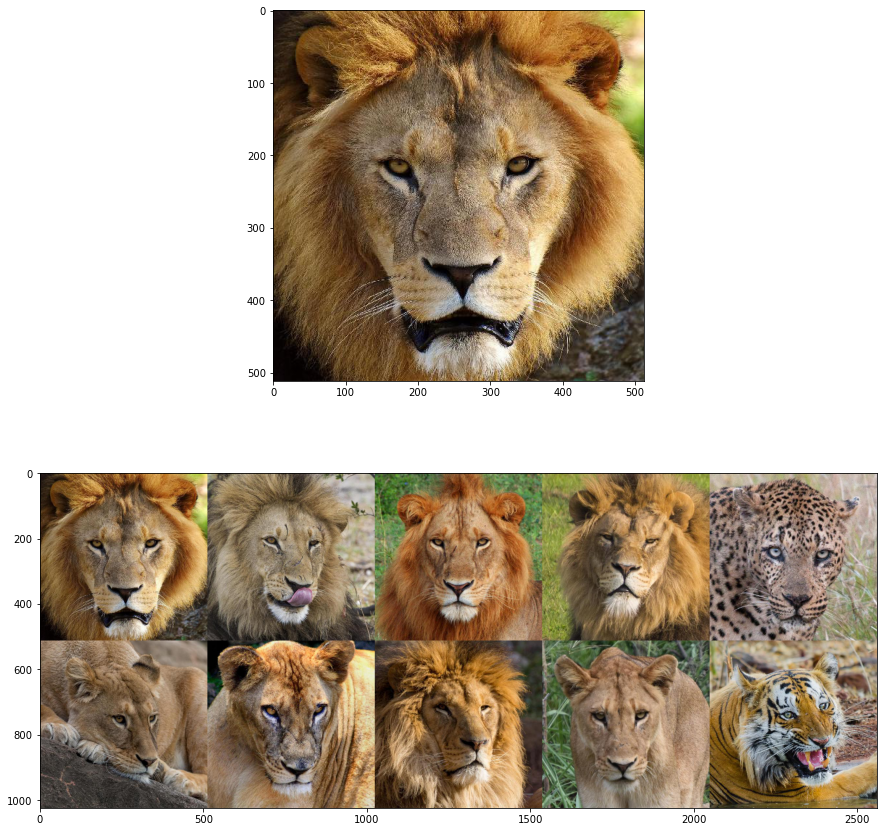

In [30]:
# take the features for the current image, find all similar
# images in our dataset, and then initialize our list of result
# images
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
queryIdx = 23 # Input Index for which images 
MAX_RESULTS = 10


queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(images[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)